# Derivatives

This notebook aims at comparing different methods to implement the FirstDerivative operator:

1. fancy indexing (as done so far in Derivative1D)
2. using Convolve1D

as well as considering different kind of derivatives:

1. Forward
2. Centered
3. Backward

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops

from scipy.sparse import csr_matrix, vstack, rand, diags
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import cg, lsqr

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

## 1D

True
True


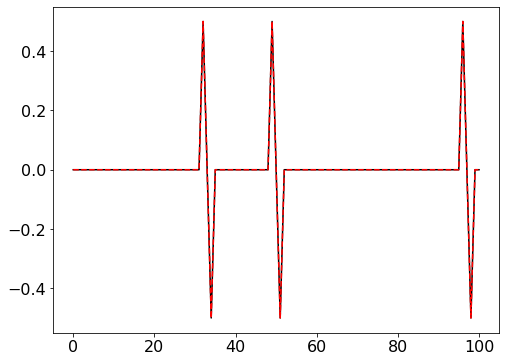

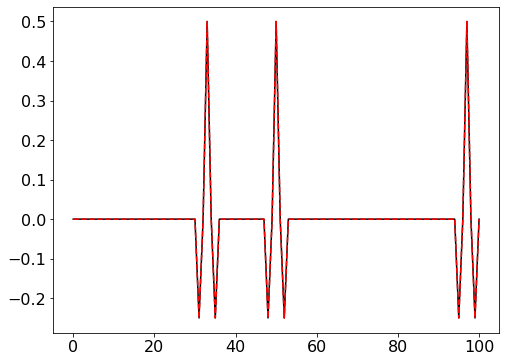

In [2]:
nx = 101
x = np.zeros(nx)
x[nx//2] = 1
x[nx//3] = 1
x[nx-4] = 1

Dop = FirstDerivative(nx, edge=True)
Dconvop = Convolve1D(nx, np.array([0.5, 0, -0.5]), offset=1)

y = Dop*x
yconv = Dconvop*x

xadj = Dop.H*y
xadjconv = Dconvop.H*y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

plt.figure()
plt.plot(y, 'k')
plt.plot(yconv, '--r')

plt.figure()
plt.plot(xadj, 'k')
plt.plot(xadjconv, '--r');

In [3]:
%timeit -n 100 -r 3 Dop.matvec(x)
%timeit -n 100 -r 3 Dconvop.matvec(x)

%timeit -n 100 -r 3 Dop.rmatvec(y)
%timeit -n 100 -r 3 Dconvop.rmatvec(y)

9.21 µs ± 575 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)
13.3 µs ± 2.15 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
14.8 µs ± 514 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)
13.5 µs ± 1.95 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


## 2D

In [4]:
nt, nx = 501, 1001 
x = np.zeros((nt, nx))
x[nt//2] = 1
x[nt//3] = 1
x[nt-4] = 1

Dop = FirstDerivative(dims=(nt, nx), axis=0)
Dconvop = Convolve1D(dims=(nt, nx), h=np.array([0.5, 0, -0.5]), offset=1, axis=0)

y = Dop*x.ravel()
yconv = Dconvop*x.ravel()

xadj = Dop.H*y
xadjconv = Dconvop.H*y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

True
True


In [5]:
%timeit -n 10 -r 3 Dop.matvec(x.ravel())
%timeit -n 10 -r 3 Dconvop.matvec(x.ravel())

%timeit -n 10 -r 3 Dop.rmatvec(y)
%timeit -n 10 -r 3 Dconvop.rmatvec(y)

1.25 ms ± 67.8 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
4.53 ms ± 50 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
2.3 ms ± 119 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
4.13 ms ± 139 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [6]:
nt, nx = 501, 1001 
x = np.zeros((nt, nx))
x[:, nx//2] = 1
x[:, nx//3] = 1
x[:, nx-4] = 1

Dop = FirstDerivative(dims=(nt, nx), axis=1)
Dconvop = Convolve1D(dims=(nt, nx), h=np.array([0.5, 0, -0.5]), offset=1, axis=1)

y = Dop*x.ravel()
yconv = Dconvop*x.ravel()

xadj = Dop.H*y
xadjconv = Dconvop.H*y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

True
True


In [7]:
%timeit -n 10 -r 3 Dop.matvec(x.ravel())
%timeit -n 10 -r 3 Dconvop.matvec(x.ravel())

%timeit -n 10 -r 3 Dop.rmatvec(y)
%timeit -n 10 -r 3 Dconvop.rmatvec(y)

1.03 ms ± 158 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
3.26 ms ± 181 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
1.89 ms ± 37.1 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
3.1 ms ± 62.3 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


## 3D

In [8]:
nt, nx, ny = 101, 201, 101
x = np.zeros((nt, nx, ny))
x[...,ny//2] = 1
x[...,ny//3] = 1
x[...,ny-4] = 1

Dop = FirstDerivative(dims=(nt, nx, ny), axis=2)
Dconvop = Convolve1D(dims=(nt, nx, ny),
                     h=np.array([0.5, 0, -0.5]), 
                     offset=1, axis=2)

y = Dop*x.ravel()
yconv = Dconvop*x.ravel()

xadj = Dop.H*y
xadjconv = Dconvop.H*y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

True
True


In [9]:
%timeit -n 10 -r 3 Dop.matvec(x.ravel())
%timeit -n 10 -r 3 Dconvop.matvec(x.ravel())

%timeit -n 10 -r 3 Dop.rmatvec(y)
%timeit -n 10 -r 3 Dconvop.rmatvec(y)

4.03 ms ± 47.7 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
13 ms ± 293 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
8.29 ms ± 165 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
12.6 ms ± 265 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


## 1D forward

Dot test passed, v^H(Opu)=17.923142596134802 - u^H(Op^Hv)=17.923142596134802
True
True
True
True


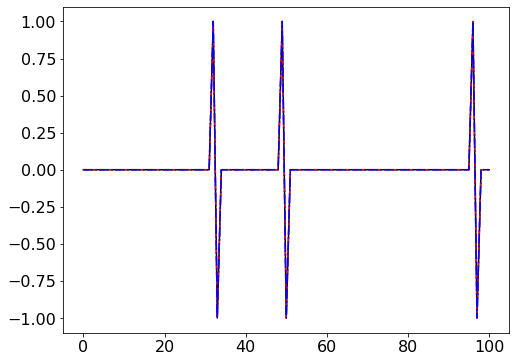

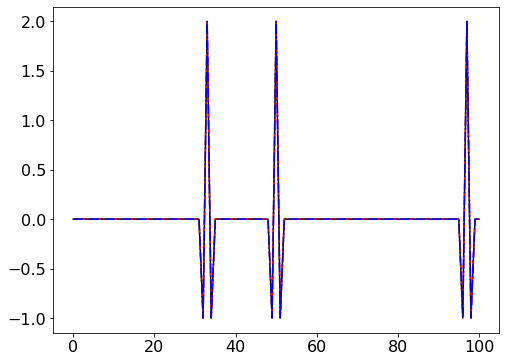

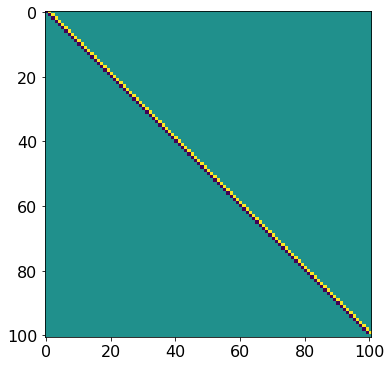

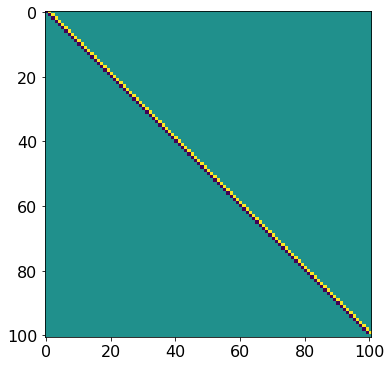

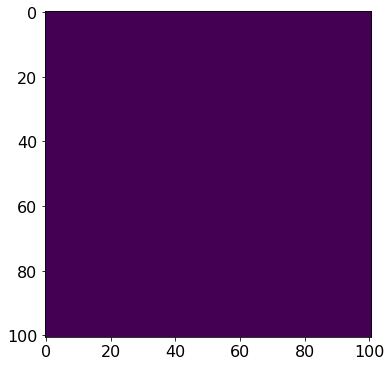

In [10]:
nx = 101
x = np.zeros(nx)
x[nx//2] = 1
x[nx//3] = 1
x[nx-4] = 1

Dop = FirstDerivative(nx, kind='forward')
Dconvop = Convolve1D(nx, np.array([1, -1]), offset=1)
Dsparse = diags([-1, 1], [0, 1], shape=(nx, nx)).tocsr()
Dsparse[nx - 1, :] = 0

dottest(Dop, nx, nx, verb=True)

y = Dop*x
yconv = Dconvop*x
ysparse = Dsparse@x

xadj = Dop.H*y
xadjconv = Dconvop.H*y
xadjsparse = Dsparse.T@y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

print(np.allclose(y, ysparse))
print(np.allclose(xadj, xadjsparse))

plt.figure()
plt.plot(y, 'k')
plt.plot(yconv, '--r')
plt.plot(ysparse, '-.b')

plt.figure()
plt.plot(xadj, 'k')
plt.plot(xadjconv, '--r')
plt.plot(xadjsparse, '-.b')

plt.figure()
plt.imshow(Dsparse.todense());

plt.figure()
plt.imshow(Dop.todense());

plt.figure()
plt.imshow(Dsparse.todense()-Dop.todense());

## 1D backward

Dot test passed, v^H(Opu)=-5.89717072191605 - u^H(Op^Hv)=-5.897170721916056
True
True
True
True


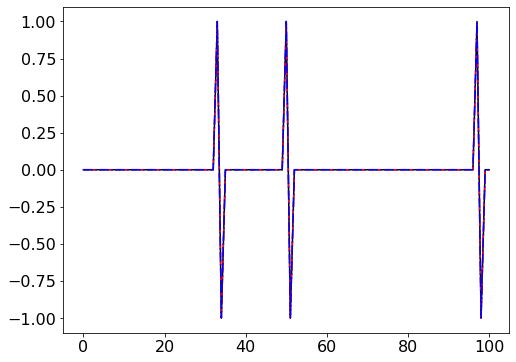

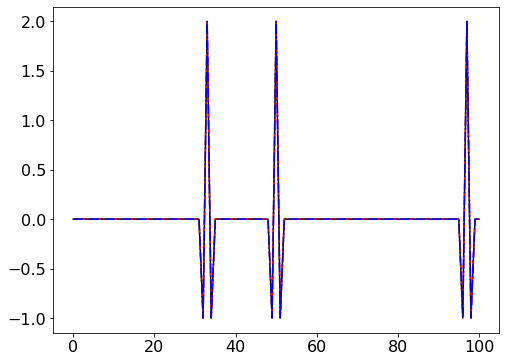

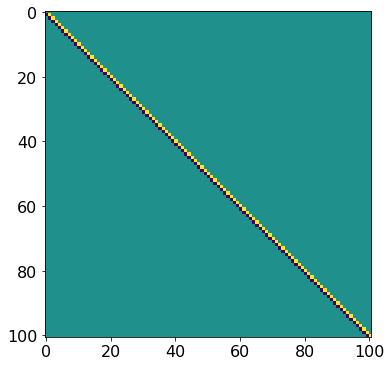

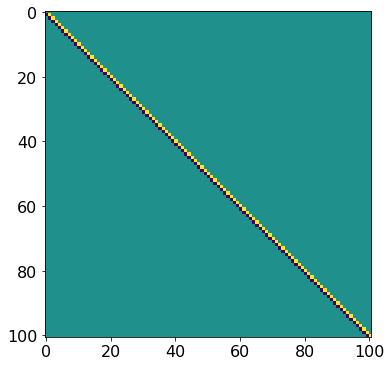

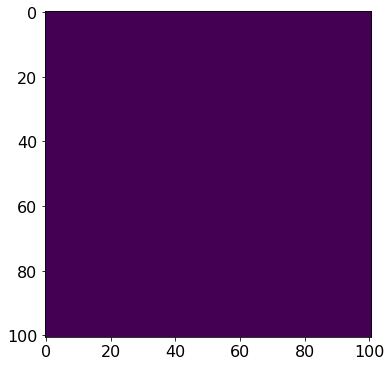

In [11]:
nx = 101
x = np.zeros(nx)
x[nx//2] = 1
x[nx//3] = 1
x[nx-4] = 1

Dop = FirstDerivative(nx, kind='backward')
Dconvop = Convolve1D(nx, np.array([1, -1]), offset=0)
Dsparse = diags([-1, 1], [-1, 0], shape=(nx, nx)).tocsr()
Dsparse[0, :] = 0

dottest(Dop, nx, nx, verb=True)

y = Dop*x
yconv = Dconvop*x
ysparse = Dsparse@x

xadj = Dop.H*y
xadjconv = Dconvop.H*y
xadjsparse = Dsparse.T@y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

print(np.allclose(y, ysparse))
print(np.allclose(xadj, xadjsparse))

plt.figure()
plt.plot(y, 'k')
plt.plot(yconv, '--r')
plt.plot(ysparse, '-.b')

plt.figure()
plt.plot(xadj, 'k')
plt.plot(xadjconv, '--r')
plt.plot(xadjsparse, '-.b')

plt.figure()
plt.imshow(Dsparse.todense());

plt.figure()
plt.imshow(Dop.todense());

plt.figure()
plt.imshow(Dsparse.todense()-Dop.todense());

In [12]:
domain_shape = (5, 10)

dx = diags([1, -1], [0, 1], shape=(domain_shape[1], domain_shape[1])).tocsr()
dx[domain_shape[1] - 1, :] = 0
dy = diags([-1, 1], [0, 1], shape=(domain_shape[0], domain_shape[0])).tocsr()
dy[domain_shape[0] - 1, :] = 0

In [13]:
dx.todense()

matrix([[ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [14]:
dy.todense()

matrix([[-1.,  1.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  0., -1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.]])

In [15]:
domain_shape = (5, 10)

dforw = diags([-1, 1], [0, 1], shape=(domain_shape[1], domain_shape[1])).tocsr()
dforw[domain_shape[1] - 1, :] = 0
dback = diags([-1, 1], [-1, 0], shape=(domain_shape[0], domain_shape[0])).tocsr()
dback[0, :] = 0

In [16]:
dforw.todense()

matrix([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [17]:
dback.todense()

matrix([[ 0.,  0.,  0.,  0.,  0.],
        [-1.,  1.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  0., -1.,  1.]])